In [55]:
import csv
import pandas as pd
import os
from matplotlib import pyplot as plt

In [23]:
file = os.path.join('Resources','Crimes_2001_to_present.csv')
print("step1")
crimes_df = pd.read_csv(file)

# data clean up 
print("step2")
cols = ['ID', 'Case Number', 'Date', 'Primary Type']
crimes_df = crimes_df.loc[:, cols]
crimes_df = crimes_df[crimes_df['Primary Type'] != 'NON - CRIMINAL' ]
crimes_df = crimes_df[crimes_df['Primary Type'] != 'NON-CRIMINAL' ] 
crimes_df = crimes_df[crimes_df['Primary Type'] != 'NON-CRIMINAL (SUBJECT SPECIFIED)' ] 
print("step3")

step1
step2
step3


In [24]:
print("step3")
crimes_df['Date'] = pd.to_datetime(crimes_df['Date']).dt.date
print("step4   type(crime_df[Date])=", crimes_df['Date'].dtype)
crimes_groupedby_df = crimes_df.groupby(['Primary Type','Date'])
print("step5")
crimes_counts = crimes_groupedby_df["ID"].count()
print("step6")
crimes_counts

step3
step4   type(crime_df[Date])= object
step5
step6


Primary Type       Date      
ARSON              2001-01-03     1
                   2001-01-04     1
                   2001-01-05     3
                   2001-01-06     4
                   2001-01-08     3
                   2001-01-09     3
                   2001-01-10     2
                   2001-01-11     2
                   2001-01-12     4
                   2001-01-13     5
                   2001-01-14     1
                   2001-01-15     1
                   2001-01-17     3
                   2001-01-18     2
                   2001-01-19     2
                   2001-01-20     6
                   2001-01-22     1
                   2001-01-23     3
                   2001-01-24     1
                   2001-01-26     2
                   2001-01-27     2
                   2001-01-28     4
                   2001-01-29     3
                   2001-01-30     4
                   2001-01-31     4
                   2001-02-01     5
                   2001-02-03     

In [25]:
print(type(crimes_counts))
crimes_count_df = pd.DataFrame(crimes_counts).reset_index()
print(type(crimes_count_df))
crimes_count_df.columns = [ 'Offense Type', 'Date', 'Crime Count' ]
print("type of crime_df Date=", crimes_df['Date'].dtype)
print("type of crime_count_df Date=", crimes_count_df['Date'].dtype)
crimes_count_df


<class 'pandas.core.series.Series'>
<class 'pandas.core.frame.DataFrame'>
type of crime_df Date= object
type of crime_count_df Date= object


,Offense Type,Date,Crime Count
0,ARSON,2001-01-03,1
1,ARSON,2001-01-04,1
2,ARSON,2001-01-05,3
3,ARSON,2001-01-06,4
4,ARSON,2001-01-08,3
5,ARSON,2001-01-09,3
6,ARSON,2001-01-10,2
7,ARSON,2001-01-11,2
8,ARSON,2001-01-12,4
9,ARSON,2001-01-13,5


In [26]:
# get the free weather historial csv data set from
# https://www.meteoblue.com/products/historyplus/download/basel_switzerland_2661604
file = os.path.join('Resources','weather_2001_present.csv')
weather_df = pd.read_csv(file)

# data clean up 
weather_df = weather_df.dropna(axis=1, how='any')

# Create Date from Year, Month, Day
weather_df.reset_index()
# Reformat Date from Year, Month, Day 
#  weather_df['Date'] = weather_df['Month'].map(str) + '/' + weather_df['Day'].map(str) + '/' + weather_df['Year'].map(str)
weather_df['Date'] = pd.to_datetime(weather_df[['Month', 'Day', 'Year']])
weather_df['Year'] = weather_df['Date'].dt.to_period('Y').apply(str)
weather_df['Month'] = weather_df['Date'].dt.to_period('M').apply(str)
weather_df['Date'] = weather_df['Date'].dt.date
# Delete Year, Month, Day column
weather_df = weather_df.drop(['Day'], axis = 1) 

weather_df = weather_df.dropna(axis=1, how='any')

# Reorder the Date to the first column and select the column interested
cols = list(weather_df)
cols.insert(0, cols.pop(cols.index('Date')))
cols = cols[0:7] + cols[8:9] + cols[12:13] + cols[18:19]

# finalize the weather data frame
weather_df = weather_df.loc[:, cols]
print('weather_df Date .dtyp=',weather_df['Date'].dtype, "  weather_dfYear' .dtyp=",weather_df['Year'].dtype, \
       "  weather_df Month' .dtyp=",weather_df['Month'].dtype )
weather_df

weather_df Date .dtyp= object   weather_dfYear' .dtyp= object   weather_df Month' .dtyp= object


,Date,Year,Month,Temperature daily mean [2 m above gnd],Relative Humidity daily mean [2 m above gnd],Mean Sea Level Pressure daily mean [MSL],Total Precipitation (low resolution) daily sum [sfc],Total Cloud Cover daily mean [sfc],Sunshine Duration daily sum [sfc],Wind Speed daily mean [900 mb]
0,2001-01-01,2001,2001-01,41.46,83.58,1007.89,0.5,94.92,-984.96,16.94
1,2001-01-02,2001,2001-01,43.70,98.46,1004.75,22.0,87.54,0.00,14.48
2,2001-01-03,2001,2001-01,43.06,93.04,1011.64,0.0,64.94,109.32,30.58
3,2001-01-04,2001,2001-01,41.25,92.21,1009.52,5.7,100.00,0.00,24.18
4,2001-01-05,2001,2001-01,42.82,94.79,1004.65,3.2,95.33,0.00,24.48
5,2001-01-06,2001,2001-01,47.45,90.21,1006.51,10.8,100.00,0.00,21.67
6,2001-01-07,2001,2001-01,40.17,91.54,1013.74,13.0,100.00,0.00,3.39
7,2001-01-08,2001,2001-01,43.01,86.79,1014.66,0.4,92.71,70.21,3.53
8,2001-01-09,2001,2001-01,38.71,82.67,1017.38,0.0,45.04,400.45,10.08
9,2001-01-10,2001,2001-01,42.84,79.88,1013.40,0.0,100.00,0.00,22.00


In [37]:
# merge
crimes_weater_df = pd.merge(crimes_count_df, weather_df, on="Date", how="left")
print(crimes_weater_df.head(3))
cols = list(crimes_weater_df)
print(cols)
cols = [cols[1]] + cols[3:5] + cols[0:1] + cols[2:3] + cols[5:]
crimes_weater_df = crimes_weater_df.loc[:, cols]
crimes_weater_df = crimes_weater_df.dropna(axis=0, how='any')
# change all values to integer
for col in cols[5:]:
    crimes_weater_df[col] = crimes_weater_df[col].round(0).astype(int)
crimes_weater_df


  Offense Type        Date  Crime Count  Year    Month  \
0        ARSON  2001-01-03            1  2001  2001-01   
1        ARSON  2001-01-04            1  2001  2001-01   
2        ARSON  2001-01-05            3  2001  2001-01   

   Temperature daily mean [2 m above gnd]  \
0                                   43.06   
1                                   41.25   
2                                   42.82   

   Relative Humidity daily mean [2 m above gnd]  \
0                                         93.04   
1                                         92.21   
2                                         94.79   

   Mean Sea Level Pressure daily mean [MSL]  \
0                                   1011.64   
1                                   1009.52   
2                                   1004.65   

   Total Precipitation (low resolution) daily sum [sfc]  \
0                                                0.0      
1                                                5.7      
2              

,Date,Year,Month,Offense Type,Crime Count,Temperature daily mean [2 m above gnd],Relative Humidity daily mean [2 m above gnd],Mean Sea Level Pressure daily mean [MSL],Total Precipitation (low resolution) daily sum [sfc],Total Cloud Cover daily mean [sfc],Sunshine Duration daily sum [sfc],Wind Speed daily mean [900 mb]
0,2001-01-03,2001,2001-01,ARSON,1,43,93,1012,0,65,109,31
1,2001-01-04,2001,2001-01,ARSON,1,41,92,1010,6,100,0,24
2,2001-01-05,2001,2001-01,ARSON,3,43,95,1005,3,95,0,24
3,2001-01-06,2001,2001-01,ARSON,4,47,90,1007,11,100,0,22
4,2001-01-08,2001,2001-01,ARSON,3,43,87,1015,0,93,70,4
5,2001-01-09,2001,2001-01,ARSON,3,39,83,1017,0,45,400,10
6,2001-01-10,2001,2001-01,ARSON,2,43,80,1013,0,100,0,22
7,2001-01-11,2001,2001-01,ARSON,2,47,93,1017,4,100,0,11
8,2001-01-12,2001,2001-01,ARSON,4,43,92,1020,0,94,0,14
9,2001-01-13,2001,2001-01,ARSON,5,31,78,1025,0,9,508,39


In [29]:

file = os.path.join('Resources','merged_crimes_weather.csv')
crimes_weater_df.to_csv(file)
                      

In [9]:
crimes_types = { i for i in crimes_weater_df['Offense Type']}
crimes_types

{'ARSON',
 'ASSAULT',
 'BATTERY',
 'BURGLARY',
 'CONCEALED CARRY LICENSE VIOLATION',
 'CRIM SEXUAL ASSAULT',
 'CRIMINAL DAMAGE',
 'CRIMINAL TRESPASS',
 'DECEPTIVE PRACTICE',
 'DOMESTIC VIOLENCE',
 'GAMBLING',
 'HOMICIDE',
 'HUMAN TRAFFICKING',
 'INTERFERENCE WITH PUBLIC OFFICER',
 'INTIMIDATION',
 'KIDNAPPING',
 'LIQUOR LAW VIOLATION',
 'MOTOR VEHICLE THEFT',
 'NARCOTICS',
 'OBSCENITY',
 'OFFENSE INVOLVING CHILDREN',
 'OTHER NARCOTIC VIOLATION',
 'OTHER OFFENSE',
 'PROSTITUTION',
 'PUBLIC INDECENCY',
 'PUBLIC PEACE VIOLATION',
 'RITUALISM',
 'ROBBERY',
 'SEX OFFENSE',
 'STALKING',
 'THEFT',
 'WEAPONS VIOLATION'}

In [54]:
offense_type = 'ROBBERY'
measurement_type = 'Temperature daily mean [2 m above gnd]'
measurement_uint = 'all'
crimes_weater_df.loc[(crimes_weater_df['Offense Type'] == offense_type), \
                     [ 'Year', "Crime Count", measurement_type ]].groupby(measurement_type)['Crime Count'].sum()
crimes_weather_by_type_df =  pd.DataFrame(crimes_weater_df.loc[(crimes_weater_df['Offense Type'] == offense_type), \
                [ 'Year', "Crime Count", measurement_type ]].groupby(measurement_type)['Crime Count'].sum()).reset_index()
crimes_weather_by_type_df.columns = [ measurement_type, 'Count' ]
print(len(crimes_weather_by_type_df))
crimes_weather_by_type_df


70


,Temperature daily mean [2 m above gnd],Count
0,16,35
1,18,30
2,19,92
3,20,78
4,21,261
5,22,82
6,23,345
7,24,100
8,25,357
9,26,594


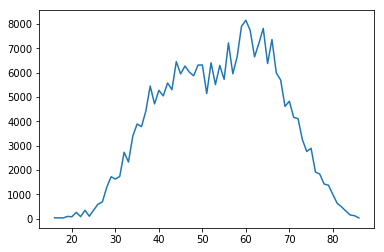

In [59]:
plt.plot(list(crimes_weather_by_type_df[measurement_type]), list(crimes_weather_by_type_df['Count']))
plt.show()